# Impact of $CO_2$ Emissions on Global Tempearature

In this case study, we utilize the worldwide temperature and $CO_2$ concentration data to uncover the role of the increase in $CO_2$ emissions on global warming.

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the data
co2_data = pd.read_csv('./carbon-emissions/carbon_emmission.csv')
temperature = pd.read_csv('./carbon-emissions/temperature.csv')

In [3]:
co2_data.head()

,ObjectId,Country,Date,Value
0,1,World,1958M03,315.70
1,2,World,1958M04,317.45
2,3,World,1958M05,317.51
3,4,World,1958M06,317.24
4,5,World,1958M07,315.86


In [4]:
temperature.head()

,ObjectId,Country,ISO2,ISO3,F1961,F1962,F1963,F1964,F1965,F1966,...,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020,F2021,F2022
0,1,"Afghanistan, Islamic Rep. of",AF,AFG,-0.113,-0.164,0.847,-0.764,-0.244,0.226,...,1.281,0.456,1.093,1.555,1.540,1.544,0.910,0.498,1.327,2.012
1,2,Albania,AL,ALB,0.627,0.326,0.075,-0.166,-0.388,0.559,...,1.333,1.198,1.569,1.464,1.121,2.028,1.675,1.498,1.536,1.518
2,3,Algeria,DZ,DZA,0.164,0.114,0.077,0.250,-0.100,0.433,...,1.192,1.690,1.121,1.757,1.512,1.210,1.115,1.926,2.330,1.688
3,4,American Samoa,AS,ASM,0.079,-0.042,0.169,-0.140,-0.562,0.181,...,1.257,1.170,1.009,1.539,1.435,1.189,1.539,1.430,1.268,1.256
4,5,"Andorra, Principality of",AD,AND,0.736,0.112,-0.752,0.308,-0.490,0.415,...,0.831,1.946,1.690,1.990,1.925,1.919,1.964,2.562,1.533,3.243


In [5]:
# Extracting values and calculating stats
temperature_values = temperature.filter(regex='^F').stack()
temperature_stats = {'mean': temperature_values.mean(),
                    'median': temperature_values.median(),
                    'std': temperature_values.std()}

co2_values = co2_data['Value']
co2_stats = {'mean': co2_values.mean(),
            'median': co2_values.median(),
            'std': co2_values.std()}

In [6]:
temperature_stats, co2_stats

({'mean': np.float64(0.5377713483146068),
  'median': np.float64(0.47),
  'std': np.float64(0.6553262417685113)},
 {'mean': np.float64(180.71615286624203),
  'median': np.float64(313.835),
  'std': np.float64(180.5547064041616)})

# Time-series Analysis

## Scatter plot

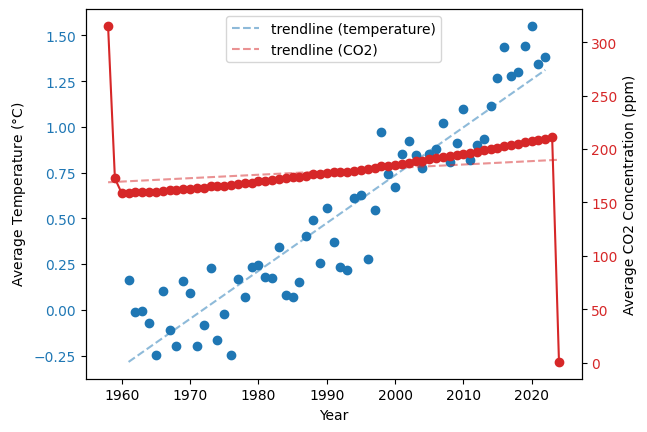

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# temperature: averaging across countries for each year
temperature_years = temperature.filter(regex='^F').mean(axis=0)
temperature_years.index = temperature_years.index.str.replace('F', '').astype(int)

## Temperature trendline
temp_trend = linregress(temperature_years.index, temperature_years.values)
temp_trend_line = temp_trend.slope * temperature_years.index + temp_trend.intercept

# CO2: parsing year and averaging monthly data
co2_data['Year'] = co2_data['Date'].str[:4].astype(int)
co2_yearly = co2_data.groupby('Year')['Value'].mean()

## CO2 trendline
co2_trend = linregress(co2_yearly.index, co2_yearly.values)
co2_trend_line = co2_trend.slope * co2_yearly.index + co2_trend.intercept

fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()

# Temperature over the years
color = 'tab:blue'
ax1.scatter(temperature_years.index, temperature_years)
ln1 = ax1.plot(temperature_years.index, temp_trend_line, ls='--', alpha=0.5, color=color, label='trendline (temperature)')
ax1.set_xlabel('Year')
ax1.set_ylabel(r'Average Temperature ($\degree$C)')
ax1.tick_params(axis ='y', labelcolor = color)

# CO2 concentration over the years
color = 'tab:red'
ax2.plot(co2_yearly.index, co2_yearly, marker='o', color=color)
ln2 = ax2.plot(co2_yearly.index, co2_trend_line, ls='--', alpha=0.5, color=color, label='trendline (CO2)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average CO2 Concentration (ppm)')
ax2.tick_params(axis ='y', labelcolor = color)

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper center')
plt.savefig('./plots/comb_plot.png')

## Correlation Matrix

In [8]:
# correlation heatmap
merged_data = pd.DataFrame({
    "Temperature Change": temperature_years,
    "CO2 Concentration": co2_yearly
}).dropna()

merged_data.corr().style.background_gradient(cmap='coolwarm')

,Temperature Change,CO2 Concentration
Temperature Change,1.000000,0.955428
CO2 Concentration,0.955428,1.000000


## Temperature vs CO2 Concentration

<Figure size 800x600 with 0 Axes>

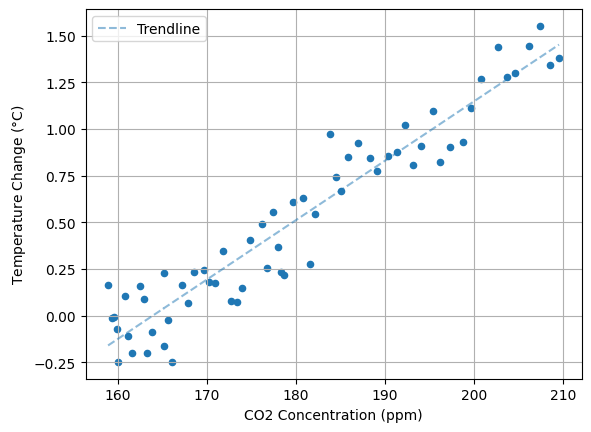

In [9]:
trend = linregress(merged_data.iloc[:,1], merged_data.iloc[:,0])
trendline = trend.slope * merged_data.iloc[:, 1] + trend.intercept

plt.figure(figsize=(8, 6))
merged_data.plot.scatter(x='CO2 Concentration', y='Temperature Change')
plt.plot(merged_data.iloc[:, 1], trendline, ls='--', alpha=0.5, label='Trendline')
plt.xlabel('CO2 Concentration (ppm)')
plt.ylabel('Temperature Change ($\degree$C)')
plt.grid()
plt.legend()
plt.savefig('./plots/temp_vs_co2.png')

The scatter plot clearly shows a positive linear correlation between CO2 concentration and temperature.

## Seasonal Variations

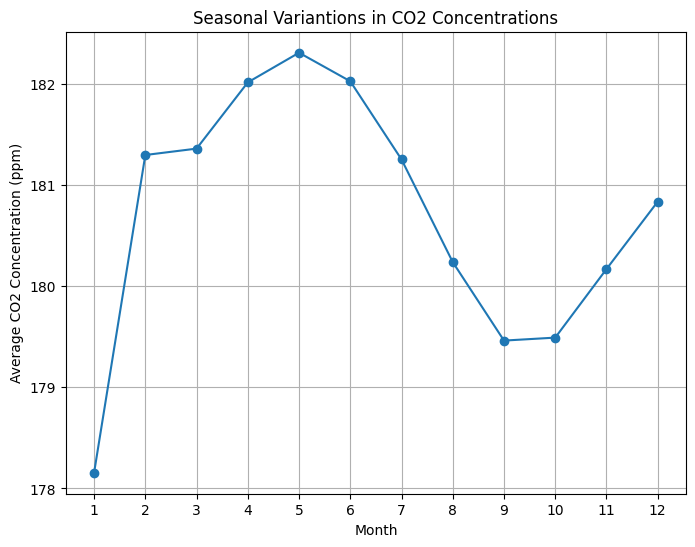

In [10]:
# seasonal variations in CO2 concentrations
co2_data['Month'] = co2_data['Date'].str[-2:].astype(int)
co2_monthly = co2_data.groupby('Month')['Value'].mean()

plt.figure(figsize=(8, 6))
co2_monthly.plot(marker='o')
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Average CO2 Concentration (ppm)')
plt.grid()
plt.title('Seasonal Variantions in CO2 Concentrations')
plt.savefig('./plots/co2_seasonal_variations.png')

## Geographical Variation

In [11]:
countries = temperature['Country']
temperature_change = temperature.filter(regex='^F').iloc[:, -1] - temperature.filter(regex='^F').iloc[:, 0]
temperature_change

0      2.125
1      0.891
2      1.524
3      1.177
4      2.507
       ...  
220    1.338
221    1.183
222      NaN
223    0.458
224   -0.757
Length: 225, dtype: float64

In [12]:
country_codes = {
    'Afghanistan, Islamic Rep. of': 'AFG',
    'Albania': 'ALB',
    'Algeria': 'DZA',
    'American Samoa': 'ASM',
    'Andorra, Principality of': 'AND',
    'Angola': 'AGO',
    'Anguilla': 'AIA',
    'Antigua and Barbuda': 'ATG',
    'Argentina': 'ARG',
    'Armenia, Rep. of': 'ARM',
    'Aruba, Kingdom of the Netherlands': 'ABW',
    'Australia': 'AUS',
    'Austria': 'AUT',
    'Azerbaijan, Rep. of': 'AZE',
    'Bahamas, The': 'BHS',
    'Bahrain, Kingdom of': 'BHR',
    'Bangladesh': 'BGD',
    'Barbados': 'BRB',
    'Belarus, Rep. of': 'BLR',
    'Belgium': 'BEL',
    'Belize': 'BLZ',
    'Benin': 'BEN',
    'Bhutan': 'BTN',
    'Bolivia': 'BOL',
    'Bosnia and Herzegovina': 'BIH',
    'Botswana': 'BWA',
    'Brazil': 'BRA',
    'British Virgin Islands': 'VGB',
    'Brunei Darussalam': 'BRN',
    'Bulgaria': 'BGR',
    'Burkina Faso': 'BFA',
    'Burundi': 'BDI',
    'Cabo Verde': 'CPV',
    'Cambodia': 'KHM',
    'Cameroon': 'CMR',
    'Canada': 'CAN',
    'Cayman Islands': 'CYM',
    'Central African Rep.': 'CAF',
    'Chad': 'TCD',
    'Chile': 'CHL',
    'China, P.R.: Hong Kong': 'HKG',
    'China, P.R.: Macao': 'MAC',
    'China, P.R.: Mainland': 'CHN',
    'Colombia': 'COL',
    'Comoros, Union of the': 'COM',
    'Congo, Dem. Rep. of the': 'COD',
    'Congo, Rep. of': 'COG',
    'Cook Islands': 'COK',
    'Costa Rica': 'CRI',
    'Croatia, Rep. of': 'HRV',
    'Cuba': 'CUB',
    'Cyprus': 'CYP',
    'Czech Rep.': 'CZE',
    'Denmark': 'DNK',
    'Djibouti': 'DJI',
    'Dominica': 'DMA',
    'Dominican Rep.': 'DOM',
    'Ecuador': 'ECU',
    'Egypt, Arab Rep. of': 'EGY',
    'El Salvador': 'SLV',
    'Equatorial Guinea, Rep. of': 'GNQ',
    'Eritrea, The State of': 'ERI',
    'Estonia, Rep. of': 'EST',
    'Eswatini, Kingdom of': 'SWZ',
    'Ethiopia, The Federal Dem. Rep. of': 'ETH',
    'Falkland Islands (Malvinas)': 'FLK',
    'Faroe Islands': 'FRO',
    'Fiji, Rep. of': 'FJI',
    'Finland': 'FIN',
    'France': 'FRA',
    'French Polynesia': 'PYF',
    'Gabon': 'GAB',
    'Gambia, The': 'GMB',
    'Georgia': 'GEO',
    'Germany': 'DEU',
    'Ghana': 'GHA',
    'Gibraltar': 'GIB',
    'Greece': 'GRC',
    'Greenland': 'GRL',
    'Grenada': 'GRD',
    'Guadeloupe': 'GLP',
    'Guatemala': 'GTM',
    'Guinea': 'GIN',
    'Guinea-Bissau': 'GNB',
    'Guyana': 'GUY',
    'Haiti': 'HTI',
    'Holy See': 'VAT',
    'Honduras': 'HND',
    'Hungary': 'HUN',
    'Iceland': 'ISL',
    'India': 'IND',
    'Indonesia': 'IDN',
    'Iran, Islamic Rep. of': 'IRN',
    'Iraq': 'IRQ',
    'Ireland': 'IRL',
    'Isle of Man': 'IMN',
    'Israel': 'ISR',
    'Italy': 'ITA',
    'Jamaica': 'JAM',
    'Japan': 'JPN',
    'Jordan': 'JOR',
    'Kazakhstan, Rep. of': 'KAZ',
    'Kenya': 'KEN',
    'Kiribati': 'KIR',
    "Korea, Dem. People's Rep. of": 'PRK',
    'Korea, Rep. of': 'KOR',
    'Kuwait': 'KWT',
    'Kyrgyz Rep.': 'KGZ',
    "Lao People's Dem. Rep.": 'LAO',
    'Latvia': 'LVA',
    'Lebanon': 'LBN',
    'Lesotho, Kingdom of': 'LSO',
    'Liberia': 'LBR',
    'Libya': 'LBY',
    'Liechtenstein': 'LIE',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Madagascar, Rep. of': 'MDG',
    'Malawi': 'MWI',
    'Malaysia': 'MYS',
    'Maldives': 'MDV',
    'Mali': 'MLI',
    'Malta': 'MLT',
    'Marshall Islands, Rep. of the': 'MHL',
    'Martinique': 'MTQ',
    'Mauritania, Islamic Rep. of': 'MRT',
    'Mauritius': 'MUS',
    'Mayotte': 'MYT',
    'Mexico': 'MEX',
    'Micronesia, Federated States of': 'FSM',
    'Moldova, Rep. of': 'MDA',
    'Monaco': 'MCO',
    'Mongolia': 'MNG',
    'Montenegro': 'MNE',
    'Montserrat': 'MSR',
    'Morocco': 'MAR',
    'Mozambique, Rep. of': 'MOZ',
    'Myanmar': 'MMR',
    'Namibia': 'NAM',
    'Nauru, Rep. of': 'NRU',
    'Nepal': 'NPL',
    'Netherlands, The': 'NLD',
    'New Caledonia': 'NCL',
    'New Zealand': 'NZL',
    'Nicaragua': 'NIC',
    'Niger': 'NER',
    'Nigeria': 'NGA',
    'Niue': 'NIU',
    'Norfolk Island': 'NFK',
    'North Macedonia, Republic of': 'MKD',
    'Norway': 'NOR',
    'Oman': 'OMN',
    'Pakistan': 'PAK',
    'Palau, Rep. of': 'PLW',
    'Panama': 'PAN',
    'Papua New Guinea': 'PNG',
    'Paraguay': 'PRY',
    'Peru': 'PER',
    'Philippines': 'PHL',
    'Pitcairn Islands': 'PCN',
    'Poland, Rep. of': 'POL',
    'Portugal': 'PRT',
    'Puerto Rico': 'PRI',
    'Qatar': 'QAT',
    'Romania': 'ROU',
    'Russian Federation': 'RUS',
    'Rwanda': 'RWA',
    'Saint Helena': 'SHN',
    'Saint Pierre and Miquelon': 'SPM',
    'Samoa': 'WSM',
    'San Marino, Rep. of': 'SMR',
    'São Tomé and Príncipe, Dem. Rep. of': 'STP',
    'Saudi Arabia': 'SAU',
    'Senegal': 'SEN',
    'Serbia, Rep. of': 'SRB',
    'Seychelles': 'SYC',
    'Sierra Leone': 'SLE',
    'Singapore': 'SGP',
    'Slovak Rep.': 'SVK',
    'Slovenia, Rep. of': 'SVN',
    'Solomon Islands': 'SLB',
    'Somalia': 'SOM',
    'South Africa': 'ZAF',
    'South Sudan, Rep. of': 'SSD',
    'Spain': 'ESP',
    'Sri Lanka': 'LKA',
    'St. Kitts and Nevis': 'KNA',
    'St. Lucia': 'LCA',
    'St. Vincent and the Grenadines': 'VCT',
    'Sudan': 'SDN',
    'Suriname': 'SUR',
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Syrian Arab Rep.': 'SYR',
    'Taiwan Province of China': 'TWN',
    'Tajikistan, Rep. of': 'TJK',
    'Tanzania, United Rep. of': 'TZA',
    'Thailand': 'THA',
    'Timor-Leste, Dem. Rep. of': 'TLS',
    'Togo': 'TGO',
    'Tokelau': 'TKL',
    'Tonga': 'TON',
    'Trinidad and Tobago': 'TTO',
    'Tunisia': 'TUN',
    'Turkmenistan': 'TKM',
    'Turks and Caicos Islands': 'TCA',
    'Tuvalu': 'TUV',
    'Uganda': 'UGA',
    'Ukraine': 'UKR',
    'United Arab Emirates': 'ARE',
    'United Kingdom': 'GBR',
    'United States': 'USA',
    'United States Virgin Islands': 'VIR',
    'Uruguay': 'URY',
    'Uzbekistan, Rep. of': 'UZB',
    'Vanuatu': 'VUT',
    'Venezuela, Rep. Bolivariana de': 'VEN',
    'Vietnam': 'VNM',
    'Wallis and Futuna Islands': 'WLF',
    'West Bank and Gaza': 'WBG',
    'Western Sahara': 'ESH',
    'World': 'WLD',
    'Yemen, Rep. of': 'YEM',
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE',
}

In [ ]:
import plotly.express as px
import pandas as pd

# Example data
df = pd.DataFrame({
    'country': countries,
    'Temperature change': temperature_change,
    'country_codes': country_codes.values()
})

# Create the choropleth map
fig = px.choropleth(df, 
                    locations="country_codes", 
                    color="Temperature change", 
                    hover_name="country", 
                    color_continuous_scale=px.colors.sequential.thermal,
                    projection="equirectangular",
                    title="Temperature Change (1961-2022)")

# Decrease padding (adjust margins)
fig.update_layout(
    width=800,  # Set width in pixels
    height=600,  # Set height in pixels
    margin={"l": 10, "r": 10, "t": 40, "b": 40}  # Decrease left, right, top, and bottom margins
)

# Shift the colorbar position to horizontal
fig.update_layout(
    coloraxis_colorbar=dict(
        orientation="h",  # Horizontal colorbar
        ypad=0,     # Padding above the colorbar
        x=0.5,             # Position the colorbar at the center
        y=-0.05,
        xanchor="center" ,  # Align the colorbar with the center
        title=r'Temperature Change',
        title_side='top'
    )
)

# Show and save the map
fig.write_image('./plots/worldmap_temperature_change.png')
fig.show()


In [ ]:
px.choropleth?

## Granger Causality Test

Granger Causality test is a statistical time series test to identify the predictive power of one time series (in this case the yearly CO2 trends) in predicting the value of the other (in this case, global average temperature trends).

For our purpose, we will use the Granger p-value to make an argument about whether increase or decrease in CO2 concentration 'Granger cause' the subsequent change in the global temperatures.

In [ ]:
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests

# pearson and spearman correlation coefficients
pearson_corr, _ = pearsonr(merged_data["CO2 Concentration"], merged_data["Temperature Change"])
spearman_corr, _ = spearmanr(merged_data["CO2 Concentration"], merged_data["Temperature Change"])

# granger causality test
granger_data = merged_data.diff().dropna()  # first differencing to make data stationary
granger_results = grangercausalitytests(granger_data, maxlag=3, verbose=False)

# extracting p-values for causality
granger_p_values = {f"Lag {lag}": round(results[0]['ssr_chi2test'][1], 4)
                    for lag, results in granger_results.items()}

pearson_corr, spearman_corr, granger_p_values

The pearson and spearman coefficients suggest a highly significant positive relationship between temperature and CO2 concentrations. From the Granger's causality test, Lag 1 is slightly above the threshold of 0.05, which suggests weak evidence of causality. While Lag 2 and Lag 3 suggest no significant evidence of causality. Thus, while there is a strong correlation between temeperature and CO2 concentration, Granger causality test doesn't give significant evidence of causality between the two.

## Lagged Effects Analysis

Now we will analyse if past CO2 concentrations cause the current temperature rises. For this, we will shift the CO2 time series by 1, 2, and 3 years and analyse if these shifted series are able to predict the temperature anomalies we see today.

In [ ]:
import statsmodels.api as sm

# creating lagged CO2 data to investigate lagged effects
merged_data['CO2 Lag 1'] = merged_data["CO2 Concentration"].shift(1)
merged_data['CO2 Lag 2'] = merged_data["CO2 Concentration"].shift(2)
merged_data['CO2 Lag 3'] = merged_data["CO2 Concentration"].shift(3)

# dropping rows with NaN due to lags
lagged_data = merged_data.dropna()

X = lagged_data[['CO2 Concentration', 'CO2 Lag 1', 'CO2 Lag 2', 'CO2 Lag 3']]
y = lagged_data['Temperature Change']
X = sm.add_constant(X)  # adding a constant for intercept

model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary

From the results, we see that coefficient of CO2 concentration is 0.32 (> 0.05) and thus is statistically significant. Interestingly, CO2 Lag 1 has coefficient -0.29 which is also statistically significant but negative. CO2 Lag 2 and Lag 3 don't show any significance.

## What if Analysis

Looking at the relationship of temperature vs CO2 concentration, we can fit a linear regression model to the data, and carry out a what-if analysis of the impact on the temperature from the change in CO2 concentration

In [ ]:
from sklearn.linear_model import LinearRegression

# Preparing data
X = merged_data[["CO2 Concentration"]].values  # CO₂ concentration as input
y = merged_data["Temperature Change"].values   # temperature change as target

temp_lr_model = LinearRegression()
temp_lr_model.fit(X, y)

# function to simulate "what-if" scenarios
def simulate_temperature_change(co2_percentage_change):
    # Calculate new CO2 concentrations
    current_mean_co2 = merged_data["CO2 Concentration"].mean()
    
    new_co2 = current_mean_co2 * (1 + co2_percentage_change / 100)

    # predict temperature change
    predicted_temp = temp_lr_model.predict([[new_co2]])
    return predicted_temp[0]

# simulating scenarios
scenarios = {
    "Increase CO2 by 10%": simulate_temperature_change(10),
    "Decrease CO2 by 10%": simulate_temperature_change(-10),
    "Increase CO2 by 20%": simulate_temperature_change(20),
    "Decrease CO2 by 20%": simulate_temperature_change(-20),
}

print(f'Current average global temperature: {merged_data["Temperature Change"].mean():.2f} celcius')
print(f'Current average global CO2 concentration: {merged_data["CO2 Concentration"].mean():.2f} ppm')
scenarios

From the analysis, we see that if the CO2 temperature increases by 10% of the current average CO2 cooncentration, the average global temperature will rise from 0.51 $\degree C$ to 1.08 $\degree C$. While, if the CO2 concentration increases by 20%, the global average temperature reaches 1.66 $\degree C$. If the CO2 concentration instead decreases by 10% or 20%, the global average temperature decreases to -0.05 $\degree C$ and -0.63 $\degree C$ respectively.

## Geographical Analysis

## Forecast

In [ ]:
plt.figure(figsize=(8, 6))
np.log(merged_data["CO2 Concentration"]).plot()
plt.xlabel('Year')
plt.ylabel('Average CO2 Concentration (ppm)')

As evident from the above plot, the relationship between year and CO2 concentration is a polynomial relationship with atleast 2 degrees. Thus, we use polynomial regression to fit a model through this data and forecast the CO2 concentration in upcoming years.

### Polynomial regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

X = np.array(merged_data.index).reshape(-1, 1)
y = merged_data['CO2 Concentration'].values

# Create polynomial regression model (degree=2 for this example)
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define the parameter grid
param_grid = {
    'polynomialfeatures__degree': range(1, 10),  # Degrees to test
    'ridge__alpha': [0.01, 0.1, 1, 10, 100],    # Regularization strengths
}

# Create the pipeline
pipeline = make_pipeline(PolynomialFeatures(), Ridge())

# Perform grid search
grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(X, y)

# Best parameters and score
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Negative MSE: {grid.best_score_}")


In [ ]:
def temp_model(co2, current_co2=180):
    co2_percent = (co2 / current_co2 - 1) * 100
    return simulate_temperature_change(co2_percent)
    
def forecast(year, co2_model, temp_model):

    year_arr = np.array([year]).reshape(-1, 1)
    co2_at_year = float(co2_model.predict(year_arr))
    temp_at_year = temp_model(co2_at_year)

    return co2_at_year, temp_at_year

In [ ]:
co2_model = grid.best_estimator_


# Forecasting the CO2 levels and global temperature for year 2050
forecast(2050, co2_model, temp_model)

According to the forecast, by year 2050, if the trends stay as they are, the CO2 concentrations will increase to 252 ppm, which will result in the global temperature to rise to 2.81 $\degree C$

In [ ]:
x_forecast = np.arange(2022, 2050).reshape(-1, 1)
co2_forecast = co2_model.predict(x_forecast)
temp_forecast = [temp_model(co2) for co2 in co2_forecast]

In [ ]:
plt.figure(figsize=(8, 6))
merged_data['CO2 Concentration'].plot(marker='o')
plt.plot(x_forecast, co2_forecast, color='gray', label = 'forecast')
plt.title('CO2 concentration forecast till 2050')
plt.legend()
plt.grid()
plt.savefig('./plots/co2_forecast.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.stats import t

X = merged_data['CO2 Concentration'].values.reshape(-1, 1)
y = merged_data['Temperature Change'].values

# Create and fit the polynomial regression model
degree = 4
model = LinearRegression()
model.fit(X, y)

# Predictions
X_pred = co2_forecast.reshape(-1, 1)  # Extend X for forecasting
y_pred = model.predict(X_pred)

# Calculate residuals
y_train_pred = model.predict(X)
residuals = y - y_train_pred
n = len(y)
p = degree + 1  # Number of predictors (including the intercept)

# Standard error of the regression
s = np.sqrt(np.sum(residuals**2) / (n - p))

# Standard error of predictions
X_poly = PolynomialFeatures(degree).fit_transform(X)
X_pred_poly = PolynomialFeatures(degree).fit_transform(X_pred)
se = s * np.sqrt(1 + np.sum((X_pred_poly @ np.linalg.pinv(X_poly.T @ X_poly) @ X_poly.T), axis=1))

# Critical t-value for 95% confidence
t_value = t.ppf(0.975, df=n - p)  # Two-tailed 95%

# Confidence intervals
upper_bound = y_pred + t_value * se
lower_bound = y_pred - t_value * se

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X, y, label="Data", color="blue")
plt.plot(X_pred, y_pred, label="Forecast Curve", color="red")
plt.fill_between(X_pred.flatten(), lower_bound, upper_bound, color="gray", alpha=0.2, label="95% Confidence Interval")
plt.xlabel("CO2 Concentration (ppm)")
plt.ylabel(r"Temperature ($\degree$C)")
plt.title('Temperature forecast till 2050')
plt.legend()
plt.grid()
plt.savefig('./plots/temp_forecast.png')
